In [1]:
import os
import hydromt_sfincs
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime as dt
import rioxarray as rio
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import hydromt
from hydromt import DataCatalog
from hydromt_sfincs import SfincsModel, utils
import cartopy.crs as ccrs

In [2]:
def calc_stats(observed, modeled):
    mae = abs(observed - modeled).values.mean()
    rmse = ((observed - modeled) ** 2).mean() ** 0.5
    bias = (modeled - observed).values.mean()
    return [round(mae, 2), round(rmse, 2), round(bias, 2)]

In [7]:
# Load in model and read results
cat_dir = r'Z:\Data-Expansion\users\lelise\data'
yml_base_CONUS = os.path.join(cat_dir, 'data_catalog_BASE_CONUS.yml')
yml_base_Carolinas = os.path.join(cat_dir, 'data_catalog_BASE_Carolinas.yml')
yml_sfincs_Carolinas = os.path.join(cat_dir, 'data_catalog_SFINCS_Carolinas.yml')

model_root = r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor\ENC_200m_sbg5m_avgN_adv1_eff75'
mod = SfincsModel(root=model_root, mode='r',
                  data_libs=[yml_base_CONUS, yml_base_Carolinas, yml_sfincs_Carolinas])
cat = mod.data_catalog
mod.read_results()

In [8]:
# Create a directory to save data and figures to
out_dir = os.path.join(os.getcwd(), model_root, 'validation', 'hwm2')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)

hwm_locs = pd.read_csv(os.path.join(out_dir, 'hwm_error_all.csv'))
hwm_locs.drop(columns='geometry', inplace=True)
hwm = gpd.GeoDataFrame(hwm_locs, geometry=gpd.points_from_xy(x=hwm_locs['xcoords'], y=hwm_locs['ycoords'], crs=32617))

In [9]:
# Update plot fonts
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})

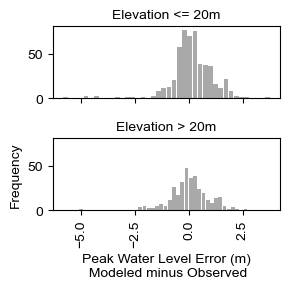

In [10]:
hwm['elev_grp'] = 'xx'
hwm['elev_grp'][hwm['elev_m'] <= 20] = 'Elevation <= 20m'
hwm['elev_grp'][(hwm['elev_m'] > 20)] = 'Elevation > 20m'
attr = 'elev_grp'
s = len(hwm[attr].unique())

# Plot historgram of peak water level errors
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(3, 3))
hwm.hist(column='error',
         ax=ax, by=attr,
         sharex=True, sharey=True,
         bins=40, grid=True,
         layout=(s, 1),
         color='darkgrey', rwidth=0.9,
         )
plt.xlabel("Peak Water Level Error (m)\n Modeled minus Observed")
plt.ylabel("Frequency")
plt.margins(x=0, y=0)
#plt.savefig(os.path.join(out_dir, 'peak_errors_wl_histogram.png'), bbox_inches='tight', dpi=225)
#plt.close()

In [ ]:
# Plot historgram of peak depth errors
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(3, 3))
hwm.hist(column='depth_error',
         ax=ax, by=attr,
         sharex=True, sharey=True,
         bins=40, grid=True,
         layout=(s, 1),
         color='darkgrey', rwidth=0.9,
         )
plt.xlabel("Peak Depth Error (m)\nModeled minus Observed")
plt.ylabel("Frequency")
plt.margins(x=0, y=0)
#plt.savefig(os.path.join(out_dir, 'peak_errors_depth_histogram.png'), bbox_inches='tight', dpi=225)
#plt.close()

In [20]:
print(hwm.columns)
hwm['depth_above_sbg'] = hwm['elev_m'] - hwm['height_above_gnd_m_sbg']

Index(['latitude_dd', 'longitude_dd', 'latitude', 'longitude', 'eventName',
       'hwmTypeName', 'hwmQualityName', 'verticalDatumName',
       'verticalMethodName', 'approvalMember', 'markerName',
       'horizontalMethodName', 'horizontalDatumName', 'flagMemberName',
       'surveyMemberName', 'site_no', 'siteDescription', 'sitePriorityName',
       'networkNames', 'stateName', 'countyName', 'siteZone',
       'sitePermHousing', 'site_latitude', 'site_longitude', 'hwm_id',
       'waterbody', 'site_id', 'event_id', 'hwm_type_id', 'hwm_quality_id',
       'hwm_locationdescription', 'survey_date', 'elev_ft', 'vdatum_id',
       'vcollect_method_id', 'bank', 'approval_id', 'marker_id',
       'height_above_gnd', 'hcollect_method_id', 'peak_summary_id',
       'hwm_notes', 'hwm_environment', 'flag_date', 'stillwater', 'hdatum_id',
       'flag_member_id', 'survey_member_id', 'uncertainty', 'hwm_uncertainty',
       'hwm_label', 'last_updated', 'last_updated_by', 'horizontal_datums',
    

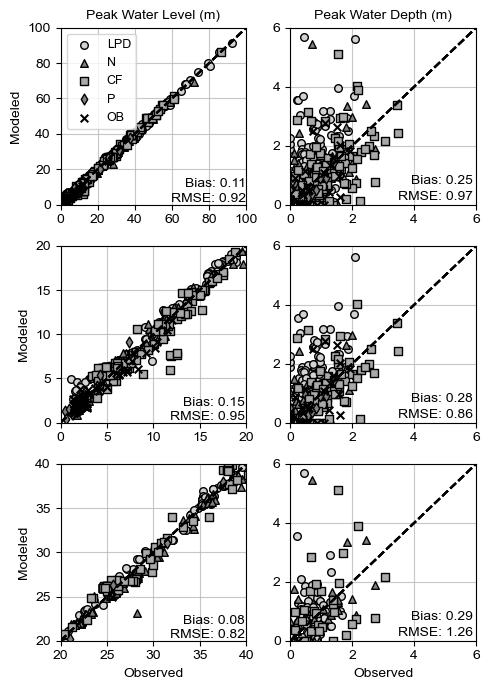

In [14]:
# QQ plot of peak water level and depth errors
nrow = 3
ncol = 2
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)
colors = ["lightgray", "gray", "darkgray", "gray", 'black']
basin = ['Lower Pee Dee', 'Neuse', 'Cape Fear', 'Pamlico', 'Onslow Bay']
legend_nick = ['LPD', 'N', 'CF', 'P', 'OB']
marker = ["o", "^", "s", "d", "x"]

# Axis limits for the subplots
axlimits = [[0, 100], [0, 20], [20, 40]]
stp = [20, 2, 5, 2, 5, 2]
text_locator = []
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, layout='constrained', figsize=(5, 7))
axs = axs.flatten()
for i in range(len(axs)):
    if i in first_row:
        axislim = axlimits[0]
    elif i in last_row:
        axislim = axlimits[2]
    else:
        axislim = axlimits[1]

    subset = hwm[(hwm['elev_m'] > axislim[0]) & (hwm['elev_m'] <= axislim[1])]
    stats_wl = calc_stats(observed=subset['elev_m'], modeled=subset['sfincs_m'])
    subset = subset[~subset['height_above_gnd_m'].isna()]
    stats_depth = calc_stats(observed=subset['height_above_gnd_m'], modeled=subset['sfincs_hmax_m'])
    ax = axs[i]
    if i in first_in_row:
        for ii in range(len(basin)):
            b = basin[ii]
            ax.scatter(hwm[hwm['Name'] == b]['elev_m'], hwm[hwm['Name'] == b]['sfincs_m'],
                       color=colors[ii], s=30, edgecolors='black', alpha=1.0, marker=marker[ii], zorder=2)
            stats = stats_wl
    else:
        for ii in range(len(basin)):
            b = basin[ii]
            ax.scatter(subset[subset['Name'] == b]['height_above_gnd_m'],
                       subset[subset['Name'] == b]['sfincs_hmax_m'],
                       color=colors[ii], s=30, edgecolors='black', alpha=1.0, marker=marker[ii], zorder=2)
            stats = stats_depth

    # row_names = ['Elev.\n0-100m', 'Elev.\n0-20m', 'Elev.\n20-40m']
    # count = 0
    # for kk in first_in_row:
    #     axs[kk].set_title(row_names[count], loc='right')
    #     count += 1
        # axs[first_in_row[kk]].text(-0.5, 0.5, row_names[kk],
        #                            horizontalalignment='left',
        #                            verticalalignment='center',
        #                            rotation='horizontal',
        #                            transform=axs[first_in_row[kk]].transAxes)
        # pos0 = axs[last_in_row[kk]].get_position()  # get the original position

    if i == 0:
        ax.set_title('Peak Water Level (m)')
    if i == 1:
        ax.set_title('Peak Water Depth (m)')

    if i in first_in_row:
        ax.set_ylabel('Modeled')
    if i in last_row:
        ax.set_xlabel('Observed')

    # Fix the axis tick marks
    if i == first_in_row[0]:
        vv = axlimits[0]
    elif i == first_in_row[1]:
        vv = axlimits[1]
    elif i == first_in_row[2]:
        vv = axlimits[2]
    else:
        vv = [0, 6]
    ax.set_xlim(vv)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end + 1, stp[i]))
    ax.set_ylim(vv)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end + 1, stp[i]))

    ax.grid(axis='both', alpha=0.7, zorder=-1)

    ss1 = 'Bias: ' + str(stats[2])
    ss2 = 'RMSE: ' + str(stats[1])
    locater = [8, 0.6, 1.6, 0.6, 1.6, 0.6]
    if i in first_in_row:
        ax.text(x=end - 0.15, y=start + locater[i], s=ss1, ha='right', va='bottom')
        ax.text(x=end - 0.15, y=start + 0.01, s=ss2, ha='right', va='bottom')
    else:
        ax.text(x=end - 0.1, y=start + locater[i], s=ss1, ha='right', va='bottom')
        ax.text(x=end - 0.1, y=start + 0.05, s=ss2, ha='right', va='bottom')

    for ax in axs:
        line = mlines.Line2D([0, 1], [0, 1], color='black', alpha=0.8, linestyle='--', zorder=3)
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        ax.margins(x=0, y=0)

axs[0].legend(legend_nick, loc='upper left', fontsize=9)
plt.subplots_adjust(wspace=0.0, hspace=0)
plt.tight_layout()
plt.margins(x=0, y=0)
#plt.savefig(os.path.join(out_dir, 'hwm_qq_plot.png'), bbox_inches='tight', dpi=225, tight_layout=True)
#plt.close()

18.940967999999998
19.301823


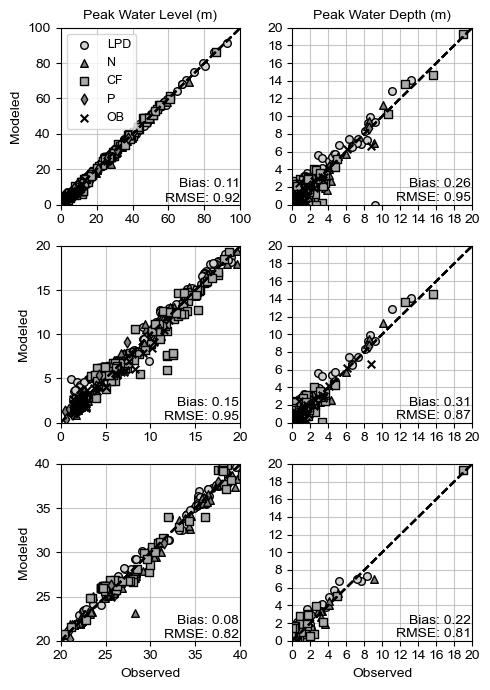

In [36]:
print(max(hwm['depth_above_sbg']))
print(max(hwm['sfincs_hmax_m']))
      
# QQ plot of peak water level and depth errors
nrow = 3
ncol = 2
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)
colors = ["lightgray", "gray", "darkgray", "gray", 'black']
basin = ['Lower Pee Dee', 'Neuse', 'Cape Fear', 'Pamlico', 'Onslow Bay']
legend_nick = ['LPD', 'N', 'CF', 'P', 'OB']
marker = ["o", "^", "s", "d", "x"]

# Axis limits for the subplots
axlimits = [[0, 100], [0, 20], [20, 40]]
stp = [20, 2, 5, 2, 5, 2]
text_locator = []
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, layout='constrained', figsize=(5, 7))
axs = axs.flatten()
for i in range(len(axs)):
    if i in first_row:
        axislim = axlimits[0]
    elif i in last_row:
        axislim = axlimits[2]
    else:
        axislim = axlimits[1]

    subset = hwm[(hwm['elev_m'] > axislim[0]) & (hwm['elev_m'] <= axislim[1])]
    stats_wl = calc_stats(observed=subset['elev_m'], modeled=subset['sfincs_m'])
    subset = subset[~subset['depth_above_sbg'].isna()]
    stats_depth = calc_stats(observed=subset['depth_above_sbg'], modeled=subset['sfincs_hmax_m'])
    ax = axs[i]
    if i in first_in_row:
        for ii in range(len(basin)):
            b = basin[ii]
            ax.scatter(hwm[hwm['Name'] == b]['elev_m'], hwm[hwm['Name'] == b]['sfincs_m'],
                       color=colors[ii], s=30, edgecolors='black', alpha=1.0, marker=marker[ii], zorder=2)
            stats = stats_wl
    else:
        for ii in range(len(basin)):
            b = basin[ii]
            ax.scatter(subset[subset['Name'] == b]['depth_above_sbg'],
                       subset[subset['Name'] == b]['sfincs_hmax_m'],
                       color=colors[ii], s=30, edgecolors='black', alpha=1.0, marker=marker[ii], zorder=2)
            stats = stats_depth

    # row_names = ['Elev.\n0-100m', 'Elev.\n0-20m', 'Elev.\n20-40m']
    # count = 0
    # for kk in first_in_row:
    #     axs[kk].set_title(row_names[count], loc='right')
    #     count += 1
        # axs[first_in_row[kk]].text(-0.5, 0.5, row_names[kk],
        #                            horizontalalignment='left',
        #                            verticalalignment='center',
        #                            rotation='horizontal',
        #                            transform=axs[first_in_row[kk]].transAxes)
        # pos0 = axs[last_in_row[kk]].get_position()  # get the original position

    if i == 0:
        ax.set_title('Peak Water Level (m)')
    if i == 1:
        ax.set_title('Peak Water Depth (m)')

    if i in first_in_row:
        ax.set_ylabel('Modeled')
    if i in last_row:
        ax.set_xlabel('Observed')

    # Fix the axis tick marks
    if i == first_in_row[0]:
        vv = axlimits[0]
    elif i == first_in_row[1]:
        vv = axlimits[1]
    elif i == first_in_row[2]:
        vv = axlimits[2]
    else:
        vv = [0, 20]
    ax.set_xlim(vv)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end + 1, stp[i]))
    ax.set_ylim(vv)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end + 1, stp[i]))

    ax.grid(axis='both', alpha=0.7, zorder=-1)

    ss1 = 'Bias: ' + str(stats[2])
    ss2 = 'RMSE: ' + str(stats[1])
    locater = [8, 0.6, 1.6, 0.6, 1.6, 0.6]
    if i in first_in_row:
        ax.text(x=end - 0.15, y=start + locater[i], s=ss1, ha='right', va='bottom')
        ax.text(x=end - 0.15, y=start + 0.01, s=ss2, ha='right', va='bottom')
    else:
        ax.text(x=end - 0.1, y=(start + locater[i] + 1), s=ss1, ha='right', va='bottom')
        ax.text(x=end - 0.1, y=start + 0.05, s=ss2, ha='right', va='bottom')

    for ax in axs:
        line = mlines.Line2D([0, 1], [0, 1], color='black', alpha=0.8, linestyle='--', zorder=3)
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        ax.margins(x=0, y=0)

axs[0].legend(legend_nick, loc='upper left', fontsize=9)
plt.subplots_adjust(wspace=0.0, hspace=0)
plt.tight_layout()
plt.margins(x=0, y=0)
plt.savefig(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor\ENC_200m_sbg5m_avgN_adv1_eff75\validation\hwm2\hwm_qq_plot_HWM_depth_relative_to_sbgDEM.png', bbox_inches='tight', dpi=300)
#plt.close()